In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pennylane as qml
import pennylane.numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import circuit

In [5]:
interface = 'autograd'

In [6]:
if interface == 'autograd':
    import pennylane.numpy as np
    dev = qml.device("default.qubit", wires=range(3))
    def reset_params():
        return 0.0 * np.ones(18)

elif interface == 'jax':
    import jax
    import jax.numpy as jnp
    # next line raises TypeError with default.qubit.jax
    # dev = qml.device("default.qubit.jax", wires=range(3))
    dev = qml.device("default.qubit", wires=range(3))
    def reset_params():
        return jnp.array([0.0] * 18)
    
elif interface == 'torch':
    import torch
    dev = qml.device("default.qubit", wires=range(3))
    def reset_params():
        return torch.tensor([0.0] * 18, requires_grad=True)

In [21]:
@qml.qnode(dev, interface=interface)
def three_spins_forward_state(params, delta_time, n=10):
    circuit.three_spins_circuit(params)
    qml.ApproxTimeEvolution(circuit.hamiltonian(), delta_time, n)
    return qml.state()

@qml.qnode(dev, interface=interface)
def three_spins_current_state(params):
    circuit.three_spins_circuit(params)
    return qml.state()

@qml.qnode(dev, interface=interface)
def three_spins_obvservables(params):
    circuit.three_spins_circuit(params)
    retvals = [qml.expval(qml.PauliX(i)) for i in range(3)]
    retvals += [qml.expval(qml.PauliZ(i)) for i in range(3)]
    return retvals


# qnode_three_spins_forward_state = qml.QNode(three_spins_forward_state, dev, interface=interface)
# qnode_three_spins_current_state = qml.QNode(three_spins_current_state, dev, interface=interface)
# qnode_three_spins_obvservables = qml.QNode(three_spins_obvservables, dev, interface=interface)

qnode_three_spins_forward_state = three_spins_forward_state
qnode_three_spins_current_state = three_spins_current_state
qnode_three_spins_obvservables = three_spins_obvservables

In [22]:
# test this works
params = reset_params()
dt = 0.0
original_state = qnode_three_spins_current_state(params)
forward_state = qnode_three_spins_forward_state(params + 0.01, dt)

qml.math.fidelity(original_state, forward_state)

0.999392295714022

In [23]:
# test this works
params = reset_params()
dt = 0.1
original_state = qnode_three_spins_current_state(params)
forward_state = qnode_three_spins_forward_state(params,dt)

qml.math.fidelity(original_state, forward_state)

0.9704090525562026

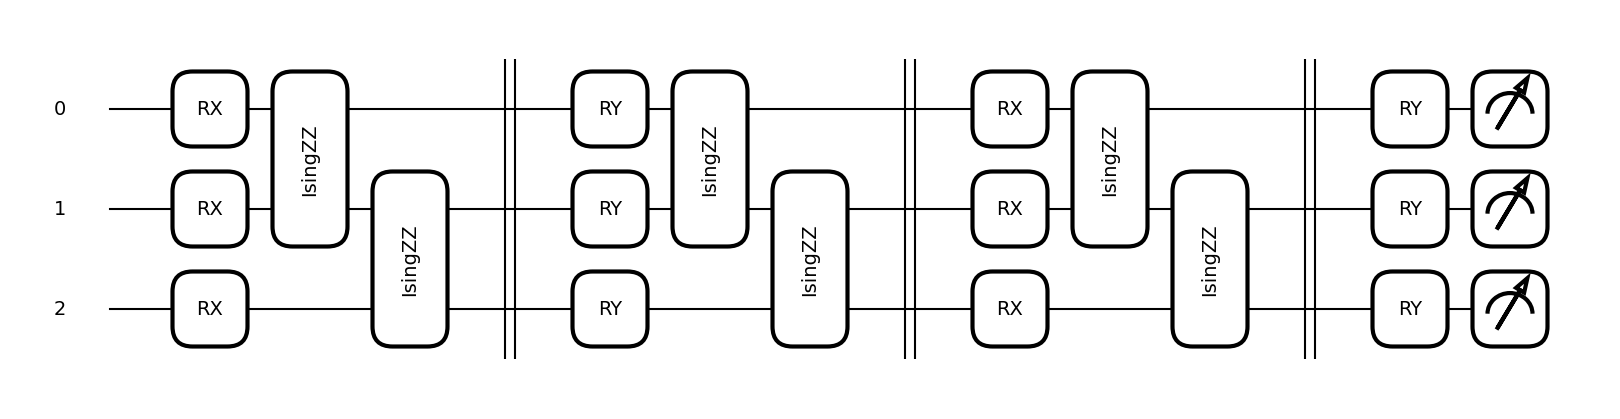

In [24]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode_three_spins_current_state)(params)
plt.show()

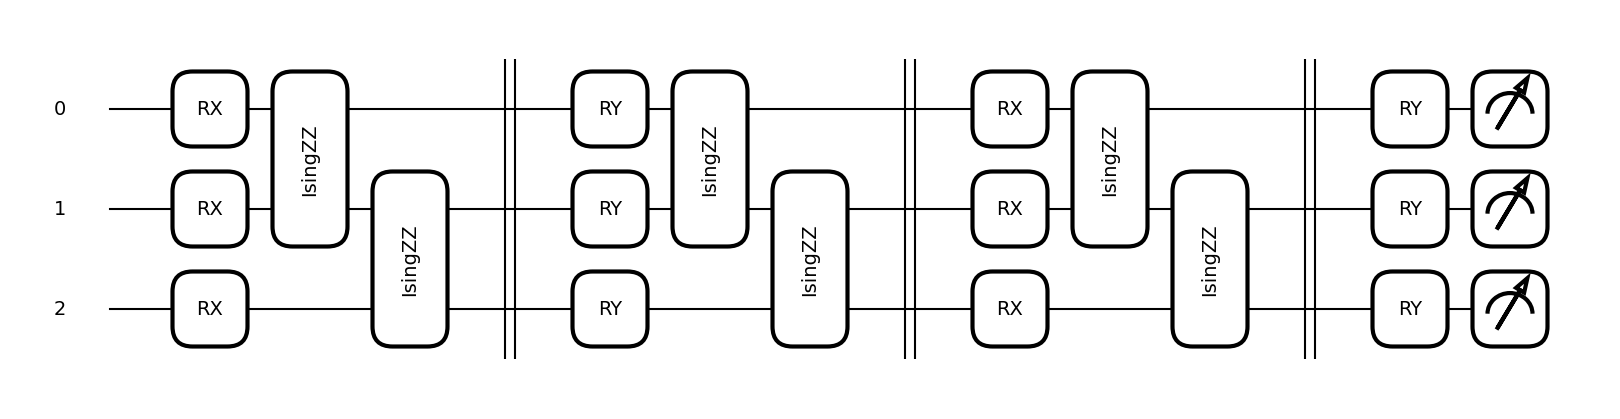

In [25]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode_three_spins_obvservables)(params)
plt.show()

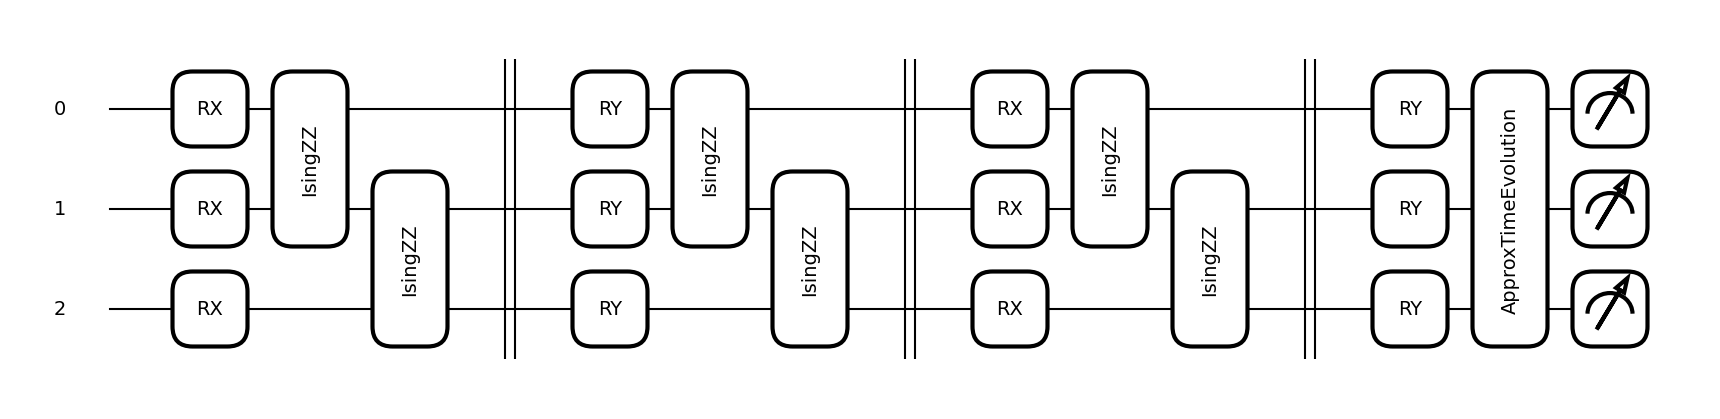

In [26]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode_three_spins_forward_state)(params, 0.1)
plt.show()

In [34]:
prev_params = params

prev_state = qnode_three_spins_current_state(prev_params)

shots = 800

def cost_function(params):
    
    forward_state = qnode_three_spins_forward_state(params, dt, shots = None)

    fidelity = qml.math.fidelity(prev_state, forward_state)
    return 1 - fidelity


recorded_costs = [cost_function(params)]


In [35]:
prev_params = params
cost_function(np.random.random(18))

0.807619557484939

In [36]:
total_time = 2.0
#total_time = 0.5
dt = 0.02
max_iterations = 500
cost_threshold = 0.0001
n_qubits = 3

prev_params = reset_params()
params = reset_params()
prev_state = qnode_three_spins_current_state(prev_params)

In [37]:
reset_params()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], requires_grad=True)

In [38]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

final_costs_v_time = []
full_costs_v_time = []
final_params_v_time = []
full_params_v_time = []
failed_to_converge_times = {}
number_of_iterations_to_converge = []
observables = []
time = []

In [39]:
for current_time in np.arange(0, total_time+dt, dt):
    print(current_time)
    
    prev_params = params
    recorded_params = [params]

    recorded_costs = [cost_function(params)]

    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_function, params)

        recorded_costs.append(cost_function(params))
        recorded_params.append(params)

        if recorded_costs[-1] <= cost_threshold:
            break

    print(f'{n} iterations to converge')
    if recorded_costs[-1] > cost_threshold:
        failed_to_converge_times[current_time] = recorded_costs[-1]
        
    
    prev_state = qnode_three_spins_current_state(recorded_params[-1])
    time.append(current_time)
    observables.append(qnode_three_spins_obvservables(params, shots = 8000))
    final_costs_v_time.append(recorded_costs[-1])
    full_costs_v_time.append(recorded_costs)
    final_params_v_time.append(recorded_params[-1])
    full_params_v_time.append(recorded_params)

0.0
11 iterations to converge
0.02
11 iterations to converge
0.04
11 iterations to converge
0.06
11 iterations to converge
0.08
11 iterations to converge
0.1
11 iterations to converge
0.12


KeyboardInterrupt: 

In [99]:
failed_to_converge_times

{}

In [100]:
observables

[tensor([ 0.0185 , -0.00425, -0.00525,  0.99575,  0.996  ,  0.99675], requires_grad=True),
 tensor([ 0.00125,  0.00525, -0.00575,  0.9835 ,  0.98375,  0.98475], requires_grad=True),
 tensor([-0.01675, -0.01475, -0.017  ,  0.96275,  0.96325,  0.9645 ], requires_grad=True),
 tensor([-0.0275 , -0.027  , -0.00375,  0.93575,  0.93975,  0.939  ], requires_grad=True),
 tensor([-0.02975, -0.0485 , -0.02925,  0.9    ,  0.91075,  0.89775], requires_grad=True),
 tensor([-0.03875, -0.0685 , -0.023  ,  0.85775,  0.8655 ,  0.865  ], requires_grad=True),
 tensor([-0.03625, -0.10275, -0.0405 ,  0.81525,  0.809  ,  0.808  ], requires_grad=True),
 tensor([-0.071  , -0.1295 , -0.06175,  0.751  ,  0.7735 ,  0.76275], requires_grad=True),
 tensor([-0.081  , -0.13425, -0.0545 ,  0.69375,  0.71725,  0.698  ], requires_grad=True),
 tensor([-0.08925, -0.155  , -0.0735 ,  0.62175,  0.62825,  0.63175], requires_grad=True),
 tensor([-0.0895 , -0.2075 , -0.0985 ,  0.55925,  0.565  ,  0.552  ], requires_grad=True),

In [101]:
sig_x = np.tensor(observables)[:,:3]
sig_z = np.tensor(observables)[:,3:]

In [102]:
sum_sig_x = np.sum(sig_x, axis=1)
sum_sig_z = np.sum(sig_z, axis=1)

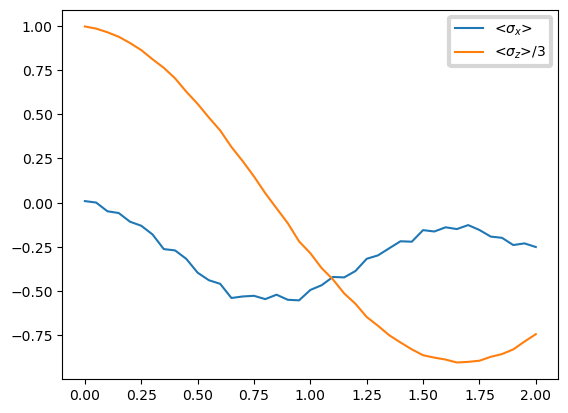

In [105]:
# expectation value of pauliX on qubit 0, 1 and 2 versus time.

plt.plot(time,sum_sig_x, label='<$\sigma_x$>')
plt.plot(time,sum_sig_z/3, label='<$\sigma_z$>/3')

plt.legend()

In [104]:
np.sum(final_costs_v_time)

0.00386857258905271